# Ireland Marriage Equality Referendum (2015)

- The referendum results were obtained from the government's open data portal (https://data.gov.ie/ga/dataset/referendum-on-the-thirty-fourth-amendment-of-the-constitution-bill-2015)
- The constituency boundaries shapefile was obtained from the Central Statistics Office website (https://www.cso.ie/en/census/census2011boundaryfiles/)

## Importing the Data and Preliminary Exploration

The relevant packages were imported, and the dataset and shapefile were loaded. 

In [62]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from matplotlib import colors

In [64]:
# Load referendum results
results = pd.read_csv("2015thirty-fourthamendment.csv", skiprows=1)

# Load shapefile
ireland_map = gpd.read_file("Constituencies_2007.shp")

The format of the dataset was investigated using the `head()` and `info()` functions, revealing 44 entries with 7 columns.

In [65]:
results.head()

,Constituency,Electorate,Total Poll,Percentage Poll,Votes in favour of proposal,Votes against proposal,Spoilt votes
0,Carlow-Kilkenny,"104,735","68,531",65.43,"38,166","29,697",668
1,Cavan-Monaghan,"99,265","56,774",57.19,"28,494","27,763",517
2,Clare,"81,809","48,627",59.44,"28,137","20,154",336
3,Cork East,"81,271","49,532",60.95,"30,383","18,845",304
4,Cork North-Central,"75,263","45,059",59.87,"28,479","16,182",398


In [68]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Constituency                 44 non-null     object 
 1   Electorate                   44 non-null     object 
 2   Total Poll                   44 non-null     object 
 3   Percentage Poll              44 non-null     float64
 4   Votes in favour of proposal  44 non-null     object 
 5   Votes against proposal       44 non-null     object 
 6   Spoilt votes                 44 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.5+ KB


The values in columns 1, 2, 4, 5 & 6 have type `object` - they were not recognised as numeric due to the decimal commas. To address this, the columns were first converted to strings in order to perform the `str.replace()` function to remove the commas, before converting them to type `int`.

In [70]:
# Remove commas and convert to numeric (int) for the relevant columns
results['Electorate'] = results['Electorate'].astype(str).str.replace(',', '').astype(int)
results['Total Poll'] = results['Total Poll'].astype(str).str.replace(',', '').astype(int)
results['Votes in favour of proposal'] = results['Votes in favour of proposal'].astype(str).str.replace(',', '').astype(int)
results['Votes against proposal'] = results['Votes against proposal'].astype(str).str.replace(',', '').astype(int)
results['Spoilt votes'] = results['Spoilt votes'].astype(str).str.replace(',', '').astype(int)

New columns were created to represent the percentage of votes in favour, against, and spoilt in each constituency. 

In [72]:
results['Percentage in Favour'] = ((results['Votes in favour of proposal'] / results['Total Poll']) * 100).round(2)
results['Percentage Against'] = ((results['Votes against proposal'] / results['Total Poll']) * 100).round(2)
results['Percentage Spoilt'] = ((results['Spoilt votes'] / results['Total Poll']) * 100).round(2)

In [74]:
results.head()

,Constituency,Electorate,Total Poll,Percentage Poll,Votes in favour of proposal,Votes against proposal,Spoilt votes,Percentage in Favour,Percentage Against,Percentage Spoilt
0,Carlow-Kilkenny,104735,68531,65.43,38166,29697,668,55.69,43.33,0.97
1,Cavan-Monaghan,99265,56774,57.19,28494,27763,517,50.19,48.90,0.91
2,Clare,81809,48627,59.44,28137,20154,336,57.86,41.45,0.69
3,Cork East,81271,49532,60.95,30383,18845,304,61.34,38.05,0.61
4,Cork North-Central,75263,45059,59.87,28479,16182,398,63.20,35.91,0.88


## Shapefile

To visualise the election results on a map, we require the geometry information obtained in the `ireland_map` shapefile.

In [76]:
ireland_map.head()

,CON_2007,CON_NAME,NO_MEMBERS,geometry
0,43,Wicklow,5,"MULTIPOLYGON (((302419.960 220863.324, 302424...."
1,17,Dublin South,5,"POLYGON ((318854.135 230304.527, 319037.399 23..."
2,12,Dublin Mid-West,4,"POLYGON ((309536.329 234960.561, 309536.769 23..."
3,18,Dublin South-Central,5,"POLYGON ((315125.724 234149.501, 315128.652 23..."
4,05,Cork North-Central,4,"MULTIPOLYGON (((164989.734 71450.468, 164979.1..."


The datasets were merged using the `Constituency` and `CON_NAME` columns. Any whitespace present in the entries was stripped, then any missing or mismatched constituencies were identified by comparing two sets.

In [78]:
print(results['Constituency'].unique())

['Carlow-Kilkenny' 'Cavan-Monaghan' 'Clare' 'Cork East'
 'Cork North-Central' 'Cork North-West' 'Cork South-Central'
 'Cork South-West' 'Donegal North-East' 'Donegal South-West'
 'Dublin Central' 'Dublin Mid-West' 'Dublin North' 'Dublin North-Central'
 'Dublin North-East' 'Dublin North-West' 'Dublin South'
 'Dublin South-Central' 'Dublin South-East' 'Dublin South-West'
 'Dublin West' 'Dun Laoghaire' 'Galway East' 'Galway West'
 'Kerry North - West Limerick' 'Kerry South' 'Kildare North'
 'Kildare South' 'Laois-Offaly' 'Limerick ' 'Limerick City'
 'Longford-Westmeath' 'Louth' 'Mayo' 'Meath East' 'Meath West'
 'Roscommon-South Leitrim' 'Sligo-North Leitrim' 'Tipperary North'
 'Tipperary South' 'Waterford' 'Wexford' 'Wicklow' 'Total']


In [80]:
print(ireland_map['CON_NAME'].unique())

['Wicklow' 'Dublin South' 'Dublin Mid-West' 'Dublin South-Central'
 'Cork North-Central' 'Clare' 'Cork East' 'Donegal North-East'
 'Donegal South-West' 'Dublin North' 'Dublin North-East' 'Dún Laoghaire'
 'Galway East' 'Kerry North-West Limerick' 'Kildare North' 'Galway West'
 'Meath East' 'Sligo-North Leitrim' 'Wexford' 'Cork South-West'
 'Cork South-Central' 'Limerick' 'Louth' 'Carlow-Kilkenny'
 'Tipperary North' 'Mayo' 'Waterford' 'Kerry South' 'Laois-Offaly'
 'Limerick City' 'Meath West' 'Kildare South' 'Dublin North-West'
 'Dublin Central' 'Tipperary South' 'Roscommon-South Leitrim'
 'Cavan-Monaghan' 'Dublin North-Central' 'Longford-Westmeath'
 'Cork North-West' 'Dublin South-West' 'Dublin South-East' 'Dublin West'
 None]


In [82]:
# Remove whitespace
results['Constituency'] = results['Constituency'].str.strip()
ireland_map['CON_NAME'] = ireland_map['CON_NAME'].str.strip()

In [84]:
# Identify missing or mismatched constituencies

missing_in_map = set(results['Constituency']).difference(ireland_map['CON_NAME'])
print("Missing in Map:", missing_in_map)

missing_in_results = set(ireland_map['CON_NAME']).difference(results['Constituency'])
print("Missing in Results:", missing_in_results)

Missing in Map: {'Kerry North - West Limerick', 'Total', 'Dun Laoghaire'}
Missing in Results: {None, 'Dún Laoghaire', 'Kerry North-West Limerick'}


Two problematic constituency names were identified and resolved: one with interior whitespace and one with a missing fada (u vs. ú). The 'Total' column was not required and was omitted from the merged dataset.

In [86]:
# Create a mapping dictionary for mismatches
rename_map = {
    "Kerry North - West Limerick": "Kerry North-West Limerick",
    "Dun Laoghaire": "Dún Laoghaire"
}

# Apply renaming
results['Constituency'] = results['Constituency'].replace(rename_map)

In [88]:
missing_in_map = set(results['Constituency']).difference(ireland_map['CON_NAME'])
print("Still Missing in Map:", missing_in_map)

Still Missing in Map: {'Total'}


In [90]:
ireland_map.rename(columns={'CON_NAME': 'Constituency'}, inplace=True)

In [92]:
# Merge the dataframes
merged_data = ireland_map.merge(results, on='Constituency', how='inner')

In [94]:
merged_data.head()

,CON_2007,Constituency,NO_MEMBERS,geometry,Electorate,Total Poll,Percentage Poll,Votes in favour of proposal,Votes against proposal,Spoilt votes,Percentage in Favour,Percentage Against,Percentage Spoilt
0,43,Wicklow,5,"MULTIPOLYGON (((302419.960 220863.324, 302424....",94275,64830,68.77,44059,20384,387,67.96,31.44,0.60
1,17,Dublin South,5,"POLYGON ((318854.135 230304.527, 319037.399 23...",103969,70543,67.85,49109,21150,284,69.62,29.98,0.40
2,12,Dublin Mid-West,4,"POLYGON ((309536.329 234960.561, 309536.769 23...",67091,42528,63.39,29984,12291,253,70.50,28.90,0.59
3,18,Dublin South-Central,5,"POLYGON ((315125.724 234149.501, 315128.652 23...",80406,48690,60.56,34988,13418,284,71.86,27.56,0.58
4,05,Cork North-Central,4,"MULTIPOLYGON (((164989.734 71450.468, 164979.1...",75263,45059,59.87,28479,16182,398,63.20,35.91,0.88


## Plot static image

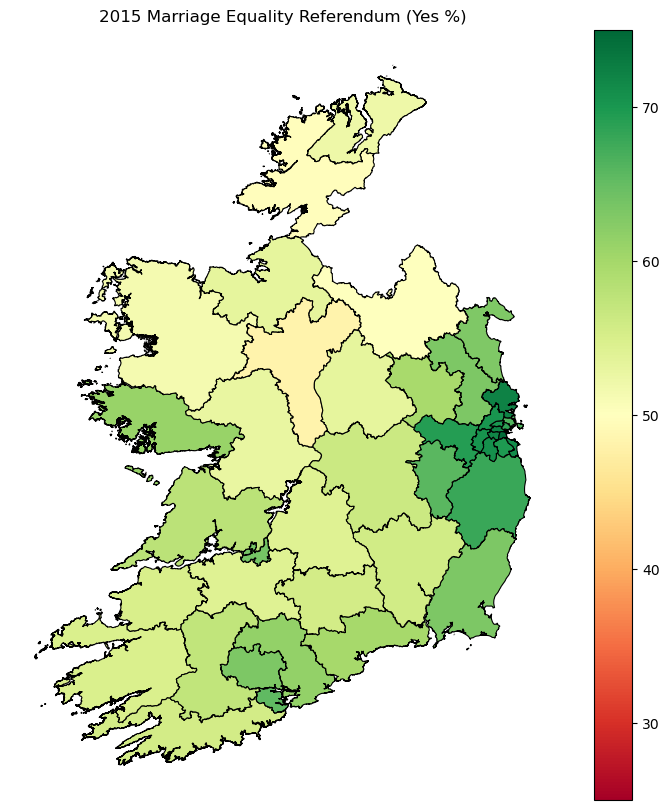

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged_data.plot(column='Percentage in Favour',  # Replace with your column (e.g., % "Yes" votes)
                 cmap='RdYlGn',           # Choose a color map
                 linewidth=0.8,           # Border width
                 edgecolor='black',       # Border color
                 legend=True,             # Add legend
                 ax=ax,
                 vmin=25,
                 vmax=75
                )

# Customize the map
ax.set_title("2015 Marriage Equality Referendum (Yes %)")
ax.axis("off")  # Turn off axis
plt.show()

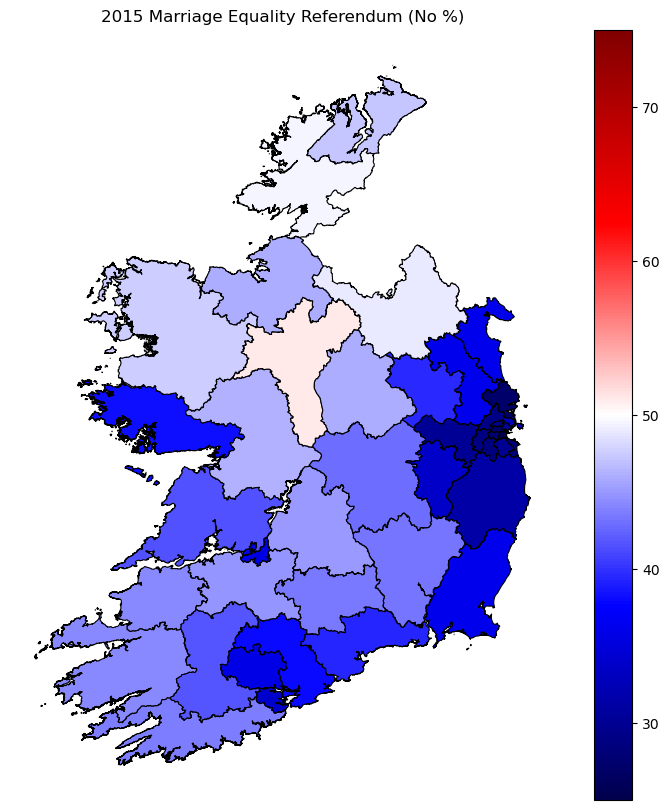

In [110]:
# Plot referendum/election results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged_data.plot(column='Percentage Against',  # Replace with your column (e.g., % "Yes" votes)
                 cmap='seismic',           # Choose a color map
                 linewidth=0.8,           # Border width
                 edgecolor='black',       # Border color
                 legend=True,             # Add legend
                 ax=ax,
                 vmin=25,
                 vmax=75
                )

# Customize the map
ax.set_title("2015 Marriage Equality Referendum (No %)")
ax.axis("off")  # Turn off axis
plt.show()

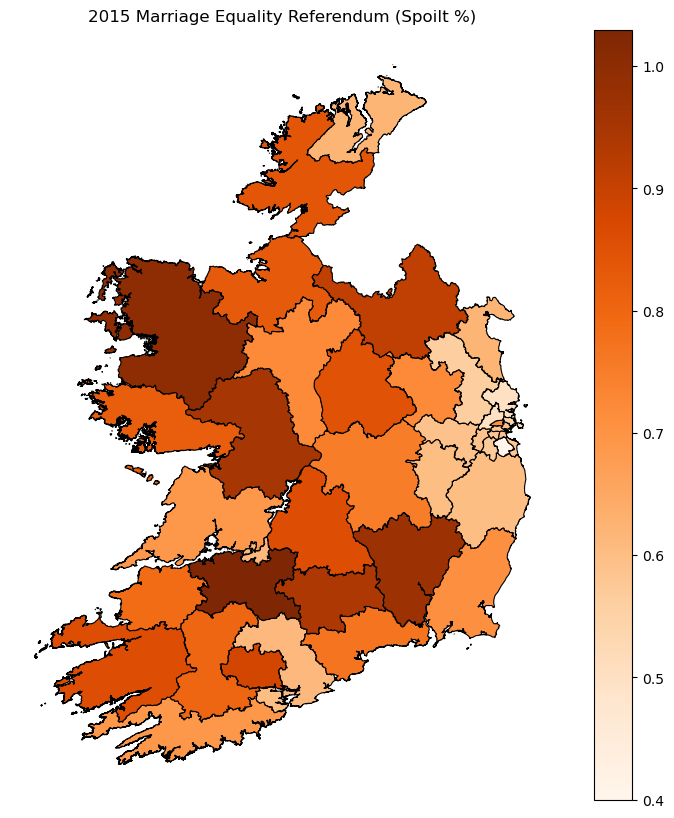

In [137]:
# Plot referendum/election results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged_data.plot(column='Percentage Spoilt',  # Replace with your column (e.g., % "Yes" votes)
                 cmap='Oranges',           # Choose a color map
                 linewidth=0.8,           # Border width
                 edgecolor='black',       # Border color
                 legend=True,             # Add legend
                 ax=ax
                )

# Customize the map
ax.set_title("2015 Marriage Equality Referendum (Spoilt %)")
ax.axis("off")  # Turn off axis
plt.show()